https://colab.research.google.com/drive/1lXdqcSyoZ_qVGUUfRSQtCoGDf1MFWxkx?usp=sharing


Use the “session_7_dataset.xlsx” for this assignment. You will find data from several properties in Madrid as well as some historical and sociodemographic data.

1. Analyze this dataset to estimate property prices as a regression problem.

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/session_7_dataset.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17857 entries, 0 to 17856
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Unnamed: 0                                       17857 non-null  int64  
 1   inm_floor                                        14067 non-null  float64
 2   inm_size                                         16090 non-null  float64
 3   inm_price                                        17857 non-null  int64  
 4   inm_longitude                                    17857 non-null  float64
 5   inm_latitude                                     17857 non-null  float64
 6   inm_barrio                                       16063 non-null  object 
 7   inm_distrito                                     16110 non-null  object 
 8   his_price                                        17857 non-null  int64  
 9   his_quarterly_variation     

(   Unnamed: 0  inm_floor  inm_size  inm_price  inm_longitude  inm_latitude  \
 0           0        3.0     141.0     990000      -3.656875     40.464347   
 1           1        2.0     159.0     940000      -3.703523     40.419427   
 2           2        NaN       NaN     549000      -3.669626     40.435362   
 3           3        2.0     232.0     750000      -3.720619     40.424164   
 4           4        4.0     183.0    1550000      -3.705909     40.413214   
 
     inm_barrio       inm_distrito  his_price  his_quarterly_variation  ...  \
 0     Canillas          Hortaleza       3250                      2.2  ...   
 1  Universidad             Centro       5106                      1.4  ...   
 2   Guindalera          Salamanca       4100                      0.6  ...   
 3    Argüelles  Moncloa - Aravaca       4773                      0.5  ...   
 4          Sol             Centro       4739                     -5.5  ...   
 
    dem_TasaDeParo  dem_TamanoMedioDelHogar  dem

Cleaning the data:
- Handle missing values through imputation.
- Remove outliers that could skew our analysis.
- Correct any inconsistencies in data types.

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Step 1: Handle missing values
# Imputation for numerical features
imputer_num = SimpleImputer(strategy='median')  # Using median to avoid the influence of outliers
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = imputer_num.fit_transform(data[numerical_cols])

# Imputation for categorical features
imputer_cat = SimpleImputer(strategy='most_frequent')  # Using the most frequent category
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])

# Step 2: Remove outliers
# We will use the IQR method to detect and remove outliers from the 'inm_price' column as an example
Q1 = data['inm_price'].quantile(0.25)
Q3 = data['inm_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['inm_price'] >= lower_bound) & (data['inm_price'] <= upper_bound)]

# Step 3: Correct any inconsistencies in data types
# Convert 'inm_floor' to integer after imputation, as it makes sense for floors to be in integer format
data['inm_floor'] = data['inm_floor'].astype(int)

# Display the shape of the dataset after cleaning and the first few rows to verify changes
data.shape, data.head()

<ipython-input-121-0ad2fa6ae36e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['inm_floor'] = data['inm_floor'].astype(int)


((16271, 26),
    Unnamed: 0  inm_floor  inm_size  inm_price  inm_longitude  inm_latitude  \
 0         0.0          3     141.0   990000.0      -3.656875     40.464347   
 1         1.0          2     159.0   940000.0      -3.703523     40.419427   
 2         2.0          2      98.0   549000.0      -3.669626     40.435362   
 3         3.0          2     232.0   750000.0      -3.720619     40.424164   
 4         4.0          4     183.0  1550000.0      -3.705909     40.413214   
 
     inm_barrio       inm_distrito  his_price  his_quarterly_variation  ...  \
 0     Canillas          Hortaleza     3250.0                      2.2  ...   
 1  Universidad             Centro     5106.0                      1.4  ...   
 2   Guindalera          Salamanca     4100.0                      0.6  ...   
 3    Argüelles  Moncloa - Aravaca     4773.0                      0.5  ...   
 4          Sol             Centro     4739.0                     -5.5  ...   
 
    dem_TasaDeParo  dem_TamanoMedi

Feature Engineering:
- Create New Features: Based on existing data, create new features that could be relevant for predicting property prices.
- Encode Categorical Variables: Use one-hot encoding to convert categorical variables into a format that can be used by regression models.
- Normalization: Scale numerical features to ensure that no variable dominates the model because of its scale.

In [ ]:
# Feature Engineering:

# 1. Price per square meter: A common metric in real estate that could provide insight into the value of a property
data['price_per_sqm'] = data.apply(lambda row: row['inm_price'] / row['inm_size'] if row['inm_size'] > 0 else np.nan, axis=1)

# Check the first few rows to verify the new features
data[['price_per_sqm']].head()

,price_per_sqm
0,7021.276596
1,5911.949686
2,5602.040816
3,3232.758621
4,8469.945355


One-hot encoding:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'data' is the original DataFrame before any encoding
categorical_cols = data.select_dtypes(include=['object']).columns

# Create the OneHotEncoder object, ensuring that it doesn't return a sparse matrix
encoder = OneHotEncoder(sparse=False, drop='first')  # 'drop=first' to avoid the dummy variable trap

# Fit and transform the categorical data with the encoder
# The output will be a NumPy array
encoded_features = encoder.fit_transform(data[categorical_cols])

# Create a DataFrame from the encoded features with the same index as the original DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(), index=data.index)

# Drop the original categorical columns from 'data' and concatenate with 'encoded_df'
data_encoded = pd.concat([data.drop(columns=categorical_cols), encoded_df], axis=1)

# Now, 'data_encoded' should not have any NaN values resulting from the encoding process
nan_rows = data_encoded[data_encoded.isnull().any(axis=1)]

# Now, displaying the shape of the new DataFrame to verify
data_encoded.shape



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(16271, 165)

Normalization:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Identifying numerical columns for scaling
# Excluding encoded categorical variables and the target variable 'inm_price' if it's intended to be the target
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.drop('inm_price') # Exclude the target variable from scaling

# Scaling the numerical features
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Verify the scaling by displaying the first few rows of the scaled features
data_encoded.head()


,Unnamed: 0,inm_floor,inm_size,inm_price,inm_longitude,inm_latitude,his_price,his_quarterly_variation,his_annual_variation,his_monthly_variation,...,inm_distrito_Moratalaz,inm_distrito_Puente de Vallecas,inm_distrito_Retiro,inm_distrito_Salamanca,inm_distrito_San Blas - Canillejas,inm_distrito_Tetuán,inm_distrito_Usera,inm_distrito_Vicálvaro,inm_distrito_Villa de Vallecas,inm_distrito_Villaverde
0,0.000000,0.065574,0.134073,990000.0,0.619205,0.758736,0.279640,0.646643,0.413194,0.548872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000056,0.049180,0.152218,940000.0,0.459465,0.508512,0.544443,0.618375,0.253472,0.398496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000112,0.049180,0.090726,549000.0,0.575542,0.597277,0.400913,0.590106,0.260417,0.375940,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000168,0.049180,0.225806,750000.0,0.400922,0.534897,0.496933,0.586572,0.274306,0.413534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000224,0.081967,0.176411,1550000.0,0.451293,0.473902,0.492082,0.374558,0.218750,0.308271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. Data Exploration and Visualization
- Correlation Analysis: Use correlation matrices to understand the relationships between different variables and the target variable (property price).


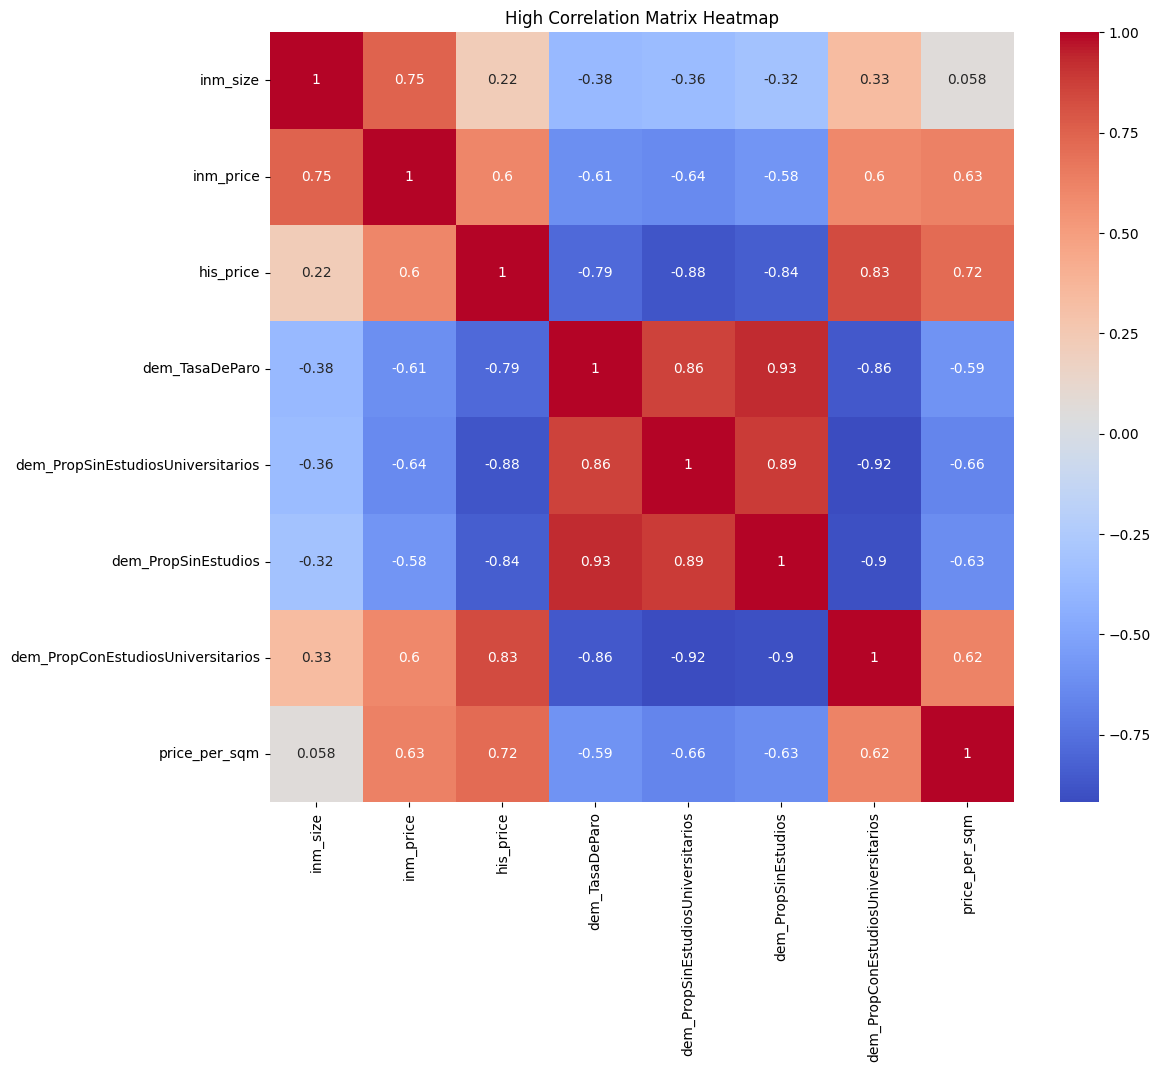

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = data_encoded.corr()

# Select columns with a correlation higher than a threshold
threshold = 0.5
high_corr_columns = corr_matrix.index[corr_matrix["inm_price"].abs() > threshold].tolist()

# Create a new correlation matrix including only the high correlation columns
high_corr_matrix = data_encoded[high_corr_columns].corr()

# Use heatmap to visualize the new, smaller correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr_matrix, xticklabels=high_corr_matrix.columns, yticklabels=high_corr_matrix.columns, cmap='coolwarm', annot=True)
plt.title('High Correlation Matrix Heatmap')
plt.show()


5. Feature Selection
Remove Irrelevant Features: Eliminate features that do not significantly contribute to the model or could introduce bias.
Dimensionality Reduction: Consider techniques like PCA (Principal Component Analysis) if the dataset is very large or if there are many correlated features to reduce the complexity of the model.

In [ ]:
# Calculate the correlation with the target variable 'inm_price'
target_corr = data_encoded.corr()['inm_price'].sort_values(key=abs, ascending=False)

# Set a threshold for minimum correlation
min_corr_threshold = 0.1

# Identify features with low correlation to 'inm_price'
low_corr_features = target_corr[abs(target_corr) < min_corr_threshold].index.tolist()

irrelevant_or_biased_features = ['Unnamed: 0']

# Combine the lists of features to drop
features_to_drop = low_corr_features + irrelevant_or_biased_features

# Drop the features from the dataset
data_selected_features = data_encoded.drop(columns=features_to_drop)

# Display the remaining features and the first few rows to verify
data_selected_features.head(), data_selected_features.shape


(   inm_floor  inm_size  inm_price  inm_latitude  his_price  \
 0   0.065574  0.134073   990000.0      0.758736   0.279640   
 1   0.049180  0.152218   940000.0      0.508512   0.544443   
 2   0.049180  0.090726   549000.0      0.597277   0.400913   
 3   0.049180  0.225806   750000.0      0.534897   0.496933   
 4   0.081967  0.176411  1550000.0      0.473902   0.492082   
 
    his_quarterly_variation  his_annual_variation  \
 0                 0.646643              0.413194   
 1                 0.618375              0.253472   
 2                 0.590106              0.260417   
 3                 0.586572              0.274306   
 4                 0.374558              0.218750   
 
    dem_Indice_de_reemplazo_de_la_poblacion_activa  dem_Indice_de_dependencia  \
 0                                        0.144891                   0.672354   
 1                                        0.049659                   0.035508   
 2                                        0.150212       

6. Prepare Training and Test Sets

- Split the Data: Divide the dataset into training and test sets to evaluate the performance of our regression model.

In [ ]:
from sklearn.model_selection import train_test_split

# First, separate the features and the target variable
X = data_selected_features.drop('inm_price', axis=1)  # Features
y = data_selected_features['inm_price']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training and 20% testing

# Output the shape of the training and testing sets for verification
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(13016, 39) (3255, 39) (13016,) (3255,)


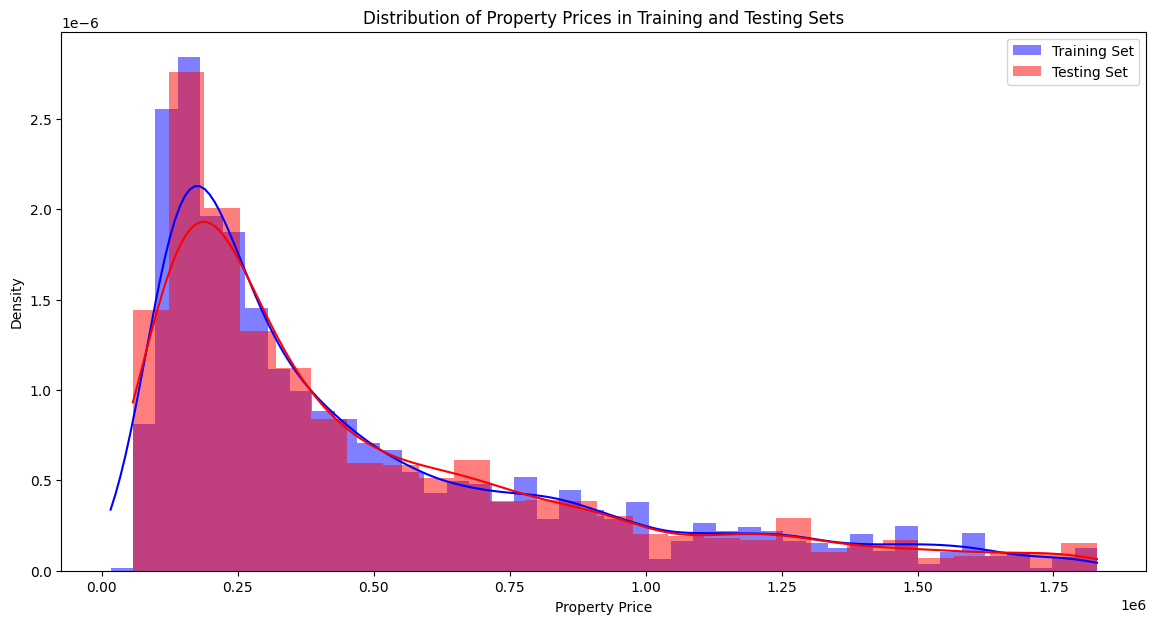

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train_reg and y_test_reg contain the target variable 'inm_price' for the training and testing sets
plt.figure(figsize=(14, 7))

# Plotting the distribution of the target variable in the training set
sns.histplot(y_train, color="blue", label="Training Set", kde=True, stat="density", linewidth=0)

# Plotting the distribution of the target variable in the testing set
sns.histplot(y_test, color="red", label="Testing Set", kde=True, stat="density", linewidth=0)

plt.title("Distribution of Property Prices in Training and Testing Sets")
plt.xlabel("Property Price")
plt.ylabel("Density")
plt.legend()
plt.show()


Linear regression:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
baseline_model = LinearRegression()

# Train the model with the training data
baseline_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = baseline_model.predict(X_test)

# Evaluate the baseline model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 13469768903.173027
R-squared (R2): 0.9187740814368863


Comparing different models:

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the models
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)  # We use alpha as a regularization strength
lasso_model = Lasso(alpha=0.1)

# Train the models
linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Make predictions using each model
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate each model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Calculate the RMSE for each model
rmse_linear = np.sqrt(mse_linear)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)

# Output the performance metrics for each model
print("Linear Regression MSE:", mse_linear, "R2:", r2_linear, "RMSE:", rmse_linear)
print("Ridge Regression MSE:", mse_ridge, "R2:", r2_ridge, "RMSE:", rmse_ridge)
print("Lasso Regression MSE:", mse_lasso, "R2:", r2_lasso, "RMSE:", rmse_lasso)


Linear Regression MSE: 13469768903.173027 R2: 0.9187740814368863 RMSE: 116059.33354613505
Ridge Regression MSE: 13696759994.230984 R2: 0.9174052710282324 RMSE: 117033.15767008504
Lasso Regression MSE: 13469787250.20439 R2: 0.9187739707999121 RMSE: 116059.4125877104


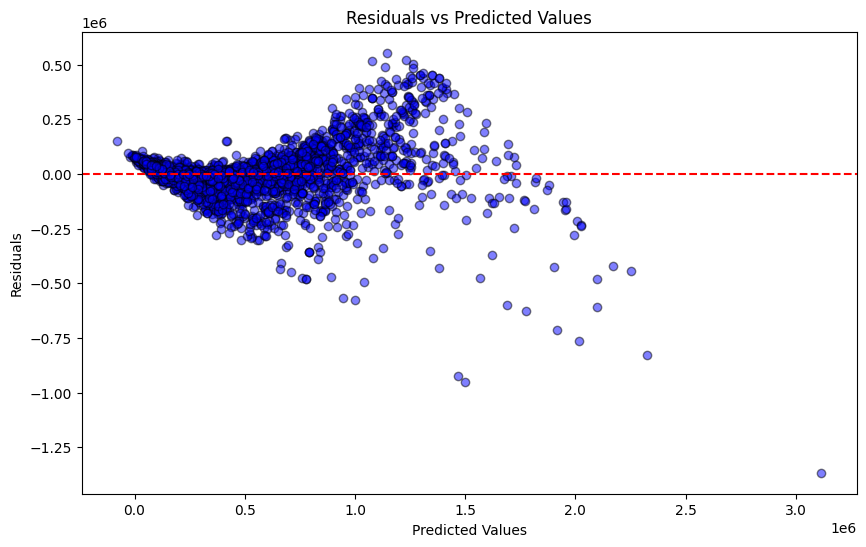

In [ ]:
import matplotlib.pyplot as plt

# 'y_pred_ridge' contains the predictions from the linear regression model
# 'y_test' is the true target values from the test set

# Calculate residuals
residuals = y_test - y_pred_ridge

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, residuals, color='blue', edgecolor='k', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


This plot shows that while the linear model may have a good predictive power overall (as indicated by a high R-squared), it may not be the best fit for all ranges of property prices.

Due to this, we can apply a log transformation in the inm_price and then perform cross validation to find the optimal alpha for lasso and ridge regression

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
d = data_selected_features
# Check the skewness of the target variable 'inm_price'
skewness = d['inm_price'].skew()
print(f"Skewness of inm_price: {skewness}")

# If the target is highly skewed, apply a log transformation
if abs(skewness) > 0.75:  # This is a commonly used threshold
    d['inm_price'] = np.log1p(d['inm_price'])

# Split the data into features and target after potential transformation
X = d.drop('inm_price', axis=1)
y = d['inm_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Lasso and Ridge regression with built-in cross-validation
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, max_iter=100000)
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)

# Fit the models
lasso_cv.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)

# Evaluate the models
y_pred_lasso = lasso_cv.predict(X_test)
y_pred_ridge = ridge_cv.predict(X_test)

# Calculate RMSE
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# Print the results
print(f"Lasso CV alpha: {lasso_cv.alpha_}")
print(f"Lasso Regression RMSE: {lasso_rmse}")

print(f"Ridge CV alpha: {ridge_cv.alpha_}")
print(f"Ridge Regression RMSE: {ridge_rmse}")

Skewness of inm_price: 1.3522629459642657
Lasso CV alpha: 1e-05
Lasso Regression RMSE: 0.21556576561626928
Ridge CV alpha: 0.1
Ridge Regression RMSE: 0.21561726200064113


The skewness of the inm_price being greater than 1 suggests that the distribution of our target variable is positively skewed (right-skewed).

The new RMSE values are on a different scale because of the log transformation, so they can't be directly compared to the previous RMSE values on the original scale. However, an RMSE of around 0.26 on the log scale indicates that the model's multiplicative error is relatively small.

2. Analyze data and redefine the problem to create a classification one.
    
    Use the following algorithms and analyze results:
    
    • Perceptron Learning Algorithm
    
    • Logistic Regression
    
    • Generative Models (LDA, QDA)
    
    • KNN

To redefine the problem as a classification one, we would first need to convert our continuous target variable (inm_price) into categorical labels.

For example we can predict whether a property's price is above or below the median price.

In [ ]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load our cleaned data
df = data_selected_features

# Convert the continuous target variable into a binary classification problem
median_price = df['inm_price'].median()
df['price_category'] = (df['inm_price'] >= median_price).astype(int)  # 1 for above or equal to median, 0 for below

# Split the data into features and target
X = df.drop(['inm_price', 'price_category'], axis=1)
y = df['price_category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for classification algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the classification models
perceptron = Perceptron()
logistic_reg = LogisticRegression()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
knn = KNeighborsClassifier()

# Train the Perceptron
perceptron.fit(X_train_scaled, y_train)
y_pred_perceptron = perceptron.predict(X_test_scaled)

# Train the Logistic Regression
logistic_reg.fit(X_train_scaled, y_train)
y_pred_logistic = logistic_reg.predict(X_test_scaled)

# Train the LDA
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)

# Train the QDA
qda.fit(X_train_scaled, y_train)
y_pred_qda = qda.predict(X_test_scaled)

# Train the KNN
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the models
print("Perceptron Accuracy:", accuracy_score(y_test, y_pred_perceptron))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print("QDA Accuracy:", accuracy_score(y_test, y_pred_qda))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

# Classification reports
print("\nClassification Report for Perceptron:")
print(classification_report(y_test, y_pred_perceptron))

print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logistic))

print("Classification Report for LDA:")
print(classification_report(y_test, y_pred_lda))

print("Classification Report for QDA:")
print(classification_report(y_test, y_pred_qda))

print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))


Perceptron Accuracy: 0.943778801843318
Logistic Regression Accuracy: 0.9609831029185868
LDA Accuracy: 0.890937019969278
QDA Accuracy: 0.8568356374807987
KNN Accuracy: 0.9253456221198156

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1630
           1       0.95      0.94      0.94      1625

    accuracy                           0.94      3255
   macro avg       0.94      0.94      0.94      3255
weighted avg       0.94      0.94      0.94      3255

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1630
           1       0.97      0.95      0.96      1625

    accuracy                           0.96      3255
   macro avg       0.96      0.96      0.96      3255
weighted avg       0.96      0.96      0.96      3255

Classification Report for LDA:
              precision    recall  f1-score

Extra - use other methods you may know and compare results with the previous ones

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train Support Vector Machine Classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

# Print classification report for SVM
print("Support Vector Machine Classifier:")
print(classification_report(y_test, svm_pred))

# Initialize and train Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# Print classification report for Random Forest
print("Random Forest Classifier:")
print(classification_report(y_test, rf_pred))


Support Vector Machine Classifier:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1630
           1       0.93      0.92      0.92      1625

    accuracy                           0.92      3255
   macro avg       0.92      0.92      0.92      3255
weighted avg       0.92      0.92      0.92      3255

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1630
           1       0.98      0.97      0.97      1625

    accuracy                           0.97      3255
   macro avg       0.97      0.97      0.97      3255
weighted avg       0.97      0.97      0.97      3255

